In [14]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data and reshape by destination for each category
def load_and_pivot(file, prefix):
    df = pd.read_csv(file)
    df_pivot = df.pivot_table(index='isochrone_file', columns='time', values='point_count', aggfunc='mean').add_prefix(prefix)
    df_pivot = df_pivot.reset_index()
    #df_pivot['y'] = df_pivot['isochrone_file'].str[15:22]  # Extract 14th to 21st characters
    #df_pivot['x'] = df_pivot['isochrone_file'].str[23:30]  # Extract 22nd to 29th characters
    df_pivot = df_pivot.fillna(0)
    return df_pivot

In [4]:
car_education = load_and_pivot("car_education.csv", "c_educ_")
car_health = load_and_pivot("car_health_and_social_action.csv", "c_health_")
car_services = load_and_pivot("car_services_for_individuals.csv", "c_services_")
car_shops = load_and_pivot("car_shops.csv", "c_shops_")
car_sports = load_and_pivot("car_sports_leisure_and_recreation.csv", "c_sports_")
car_tourism = load_and_pivot("car_tourism.csv", "c_tourism_")
car_transport = load_and_pivot("car_transport_and_travel.csv", "c_transp_")

In [5]:
# Merging all car data on 'isochrone_file'
car_merged = car_education
for df in [car_health, car_services, car_shops, car_sports, car_tourism, car_transport]:
    car_merged = car_merged.merge(df, on='isochrone_file', how='inner')

In [6]:
# Perform PCA 
def perform_pca(data):
    features = data.columns[1:]  # exclude 'isochrone_file' and  coordinates  (x and y) columns
    x = data[features]
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    explained_variance = pca.explained_variance_ratio_
    print(f'Explained variance ratio: {explained_variance}')
    return pca, principal_components

In [7]:
car_pca, car_pcs = perform_pca(car_merged)

Explained variance ratio: [0.71778939 0.12557208]


In [8]:
# Prepare the data for spatial visualization by adding back coordinates
pca_results = pd.DataFrame(car_pcs, columns = [f'PC{i+1}' for i in range(car_pcs.shape[1])])
pca_results['y'] = car_merged['isochrone_file'].str[15:22]  # Extract 14th to 21st characters
pca_results['x'] = car_merged['isochrone_file'].str[23:30]  # Extract 22nd to 29th characters

In [9]:
pca_results.shape

(5061, 4)

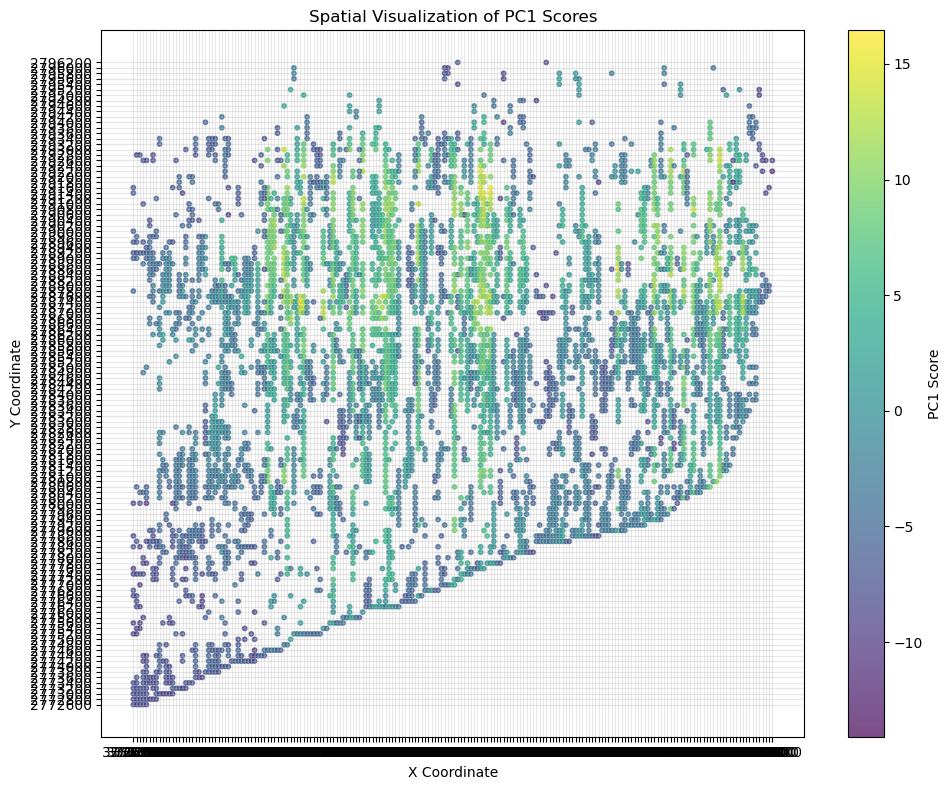

In [10]:
# Plot PCA scores for the first component (PC1) on spatial coordinates
plt.figure(figsize=(10, 8))
plt.scatter(pca_results['x'], pca_results['y'], c=pca_results['PC1'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='PC1 Score')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Spatial Visualization of PC1 Scores')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

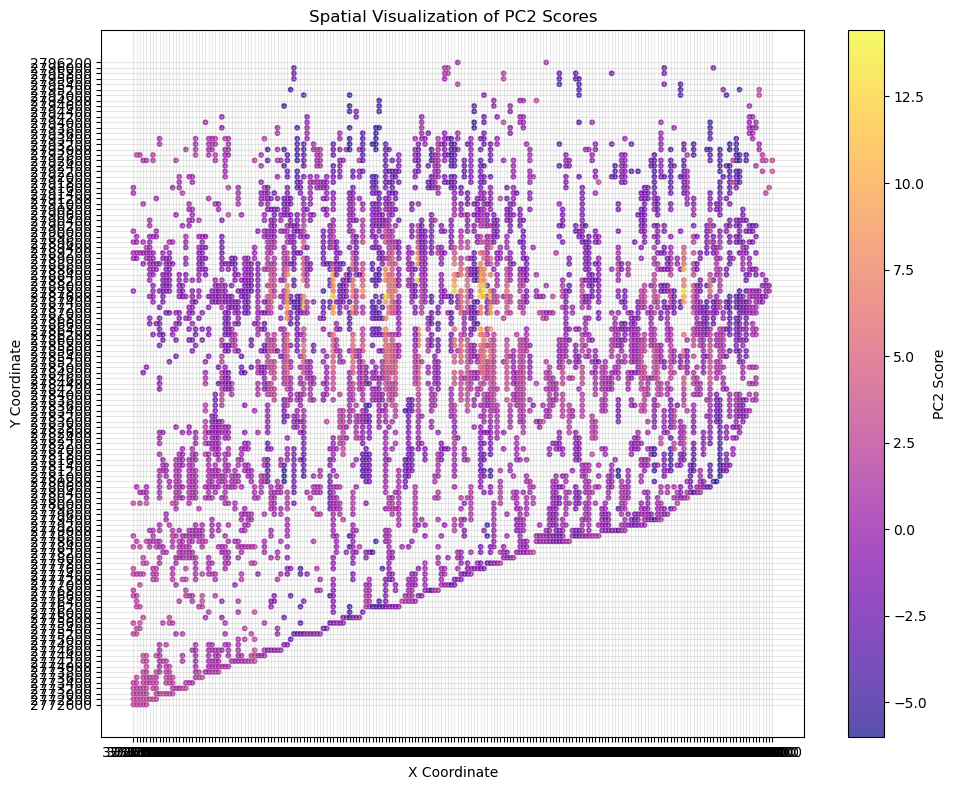

In [11]:
# Plot PCA scores for the second component (PC2) on spatial coordinates
plt.figure(figsize=(10, 8))
plt.scatter(pca_results['x'], pca_results['y'], c=pca_results['PC2'], cmap='plasma', s=10, alpha=0.7)
plt.colorbar(label='PC2 Score')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Spatial Visualization of PC2 Scores')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

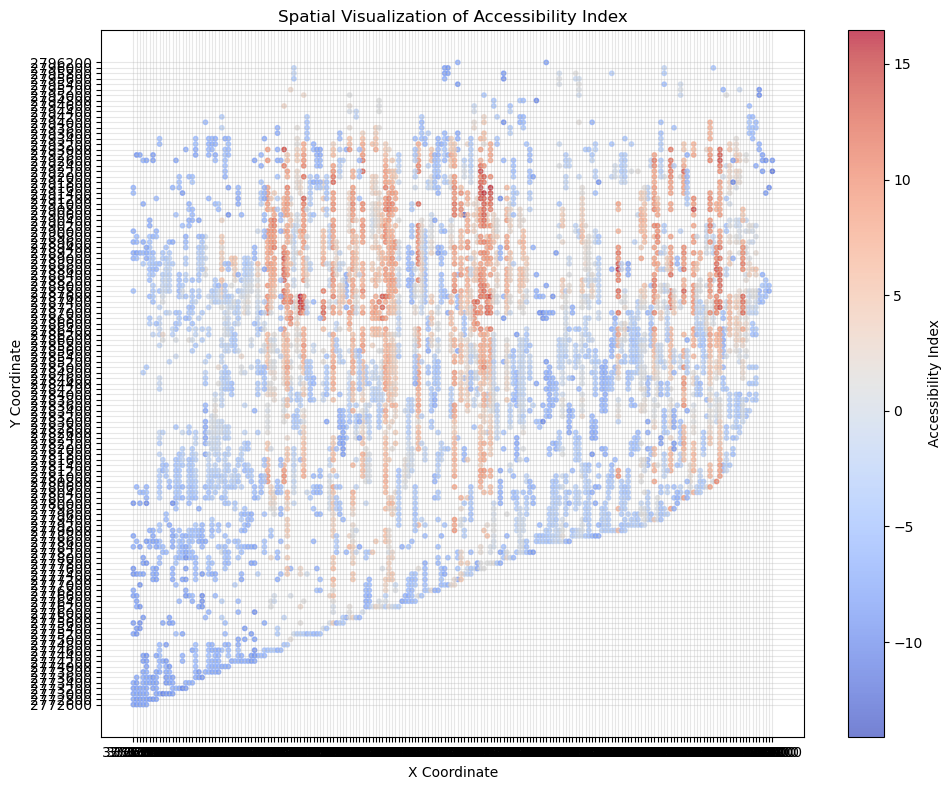

In [12]:
# Perform a second PCA on the first two principal components
pca_second = PCA(n_components=1)
composite_component = pca_second.fit_transform(pca_results[['PC1', 'PC2']])

# Add the composite component to the results dataframe
pca_results['Accessibility_Index'] = composite_component

# Spatial visualization of the composite component
plt.figure(figsize=(10, 8))
plt.scatter(pca_results['x'], pca_results['y'], c=pca_results['Accessibility_Index'], cmap='coolwarm', s=10, alpha=0.7)
plt.colorbar(label='Accessibility Index')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Spatial Visualization of Accessibility Index')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Create a GeoDataFrame from the PCA results
geometry = [Point(xy) for xy in zip(pca_results['x'], pca_results['y'])]
gdf = gpd.GeoDataFrame(pca_results, geometry=geometry)

# Specify the coordinate reference system (CRS)
gdf.set_crs("EPSG:3035", inplace=True)

# Export to a shapefile
gdf.to_file("C:/Users/kbons/accessibility/project_report/metrics/car_metrics.shp", driver="ESRI Shapefile")

print("Shapefile has been created successfully.")

Shapefile has been created successfully.


C:\Users\kbons\AppData\Local\Temp\ipykernel_16928\1613636021.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("C:/Users/kbons/accessibility/project_report/metrics/car_metrics.shp", driver="ESRI Shapefile")
C:\Users\kbons\miniconda3\envs\geo_env\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Accessibility_Index' to 'Accessibil'
  ogr_write(
